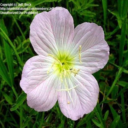

In [3]:
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt

## Create a vector of zeroes of size 5
size = (128, 128)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size), torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.Flowers102("./flowers", "train", transform=transform, download=True)
test_dataset = torchvision.datasets.Flowers102("./flowers", "test", transform=transform, download=True)

def visualize_image(img: torch.Tensor) -> Image.Image:
    return Image.fromarray((img.permute(1,2,0) * 255).to(torch.uint8).numpy())

visualize_image(train_dataset[1][0])

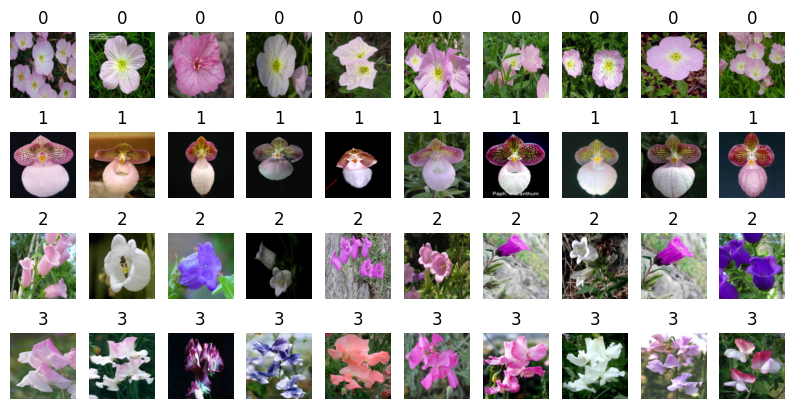

In [5]:
# First 40 images with labels
f, ax = plt.subplots(4, 10, figsize=(10, 5))
for i, (im, l) in enumerate(list(train_dataset)[:40]):
    ax[i // 10, i % 10].imshow(visualize_image(im))
    ax[i // 10, i % 10].set_title(l)
    ax[i // 10, i % 10].axis('off')

## **Step 1**: Convert the set of images into pytorch tensors

In [10]:
# First we will investigate what kind of data we have. In this case, you can see that it
# is a tuple with a tensor and a label:
print(train_dataset[0])

# We can check the types of the elements in the tuple;
print('\n')
print(type(train_dataset[0][0]))
print(type(train_dataset[0][1]))

# Since the first element is a torch tensor, we can also check its shape. We can see that
# its size is 3x128x128, which represents RGB, and the size of the image:
print('\n')
print(train_dataset[0][0].shape)

(tensor([[[0.0471, 0.0706, 0.0745,  ..., 0.1255, 0.4667, 0.5647],
         [0.0667, 0.0667, 0.0549,  ..., 0.1333, 0.4824, 0.5647],
         [0.0824, 0.0745, 0.0549,  ..., 0.1451, 0.5059, 0.5686],
         ...,
         [0.1059, 0.1059, 0.0863,  ..., 0.5020, 0.4902, 0.4706],
         [0.1137, 0.1137, 0.1294,  ..., 0.5059, 0.4784, 0.4706],
         [0.1020, 0.1176, 0.1176,  ..., 0.5020, 0.4745, 0.4667]],

        [[0.0863, 0.1255, 0.1373,  ..., 0.1294, 0.3412, 0.3961],
         [0.0941, 0.1098, 0.1059,  ..., 0.1294, 0.3490, 0.3922],
         [0.0941, 0.0941, 0.0824,  ..., 0.1294, 0.3608, 0.3843],
         ...,
         [0.2000, 0.1804, 0.1333,  ..., 0.4235, 0.4118, 0.3922],
         [0.2118, 0.2039, 0.2000,  ..., 0.4275, 0.4039, 0.3922],
         [0.2078, 0.2196, 0.2196,  ..., 0.4196, 0.4078, 0.3765]],

        [[0.0314, 0.0392, 0.0353,  ..., 0.0863, 0.4745, 0.5961],
         [0.0392, 0.0353, 0.0235,  ..., 0.0980, 0.4902, 0.5922],
         [0.0431, 0.0353, 0.0235,  ..., 0.1176, 0.5098, 0

In [16]:
# In order to convert this into a form that we can perform gradient 
# descent on, we will need to concatenate all images into one big tensor:
train_images = torch.stack([im for im, _ in train_dataset], dim=0)

# We will concatenate along the first dimension. This dimension is often called the 
# 'batch' or 'dataset' dimension, and it is enumerating all of the data elements you have.

# Let's check the shape of our tensor of concatenated images, where we will see that
# we have all 1020 images stored:
print(train_images.shape)

# Finally, we will do the same for the labels, but since the labels are not tensors, 
# we cannot use torch.stack:
train_labels = torch.tensor([l for _, l in train_dataset])
print(train_labels.shape)

torch.Size([1020, 3, 128, 128])
torch.Size([1020])


## **Step 2**: Create a model

In [49]:
# We will be using a linear model, which takes as input all of the pixels in an
# image (128x128x3) and will regress to a single value (for now):
model = torch.nn.Linear(128 * 128 * 3, 1)

# We will also need a loss function:
loss = torch.nn.MSELoss()

# And we need an optimizer, we are using a learning rate (lr) of .01, 
# which is a good learning rate for deep networks:
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

# We now have the four building blocks of a deep learning model:
# - Data
# - Model
# - Loss function
# - Optimizer

# Now we can train for a few epochs..

## **Step 3**: Train

In [73]:
for epoch in range(10):
    # Step 1: Get predicted label
    pred_label = model(train_images.view(-1, 128 * 128 * 3))
    
    # Step 2: Evaluate the loss on the predicted labels
    loss_val = loss(pred_label.view(-1), train_labels.float())
    
    # Step 3: Compute gradients
    # 3a: Set all gradients in the computation graph to 0 (or else you will build
    # up gradients as you train, and your model might explode)
    optimizer.zero_grad()
    # 3b: Add the new gradient to the computation graph (?)
    loss_val.backward()
    # 3c: Take a step in gradient descent
    optimizer.step()

    # Visualize:
    print(f"Epoch {epoch}, loss {loss_val.item()}")

# We can see that this model exploded. Why?
# 1. We are training against images with many labels and regressing to one label
# 2. We may need to adjust loss or learning rate

# Lets try again below

Epoch 0, loss 943.7181396484375
Epoch 1, loss 938.8072509765625
Epoch 2, loss 934.2041015625
Epoch 3, loss 929.875244140625
Epoch 4, loss 925.7943115234375
Epoch 5, loss 921.9384765625
Epoch 6, loss 918.287353515625
Epoch 7, loss 914.8230590820312
Epoch 8, loss 911.5299682617188
Epoch 9, loss 908.3931274414062


In [78]:
# This, time we will only train and label images with label 0 or 1
train_images_01 = train_images[train_labels <= 1]
train_labels_01 = train_labels[train_labels <= 1]

model = torch.nn.Linear(128 * 128 * 3, 1)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

for epoch in range(10):
    pred_label = model(train_images_01.view(-1, 128 * 128 * 3))
    loss_val = loss(pred_label.view(-1), train_labels_01.float())
    
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    print(f"Epoch {epoch}, loss {loss_val.item()}")

# And we can see that this is still a bad exploding model, so lets adjust learning rate
# and momentum below

Epoch 0, loss 1.288468599319458
Epoch 1, loss 239.90145874023438
Epoch 2, loss 58440.57421875
Epoch 3, loss 14242830.0
Epoch 4, loss 3471188736.0
Epoch 5, loss 845980303360.0
Epoch 6, loss 206178025996288.0
Epoch 7, loss 5.024865634693939e+16
Epoch 8, loss 1.2246352813587694e+19
Epoch 9, loss 2.9846182267015806e+21


In [79]:
train_images_01 = train_images[train_labels <= 1]
train_labels_01 = train_labels[train_labels <= 1]

model = torch.nn.Linear(128 * 128 * 3, 1)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.0001, momentum=0)

for epoch in range(10):
    pred_label = model(train_images_01.view(-1, 128 * 128 * 3))
    loss_val = loss(pred_label.view(-1), train_labels_01.float())
    
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    print(f"Epoch {epoch}, loss {loss_val.item()}")

# Now we can see that the model starts to converge

Epoch 0, loss 0.8761633038520813
Epoch 1, loss 0.5364222526550293
Epoch 2, loss 0.36874058842658997
Epoch 3, loss 0.27988606691360474
Epoch 4, loss 0.22836235165596008
Epoch 5, loss 0.1954430639743805
Epoch 6, loss 0.1724778115749359
Epoch 7, loss 0.1553179919719696
Epoch 8, loss 0.14185886085033417
Epoch 9, loss 0.13094976544380188


## **Step 4**: Check model against test data

In [80]:
# Load the test data
test_images = torch.stack([im for im, _ in test_dataset], dim=0)
test_labels = torch.tensor([l for _, l in test_dataset])

In [81]:
test_images_01 = test_images[test_labels <= 1]
test_labels_01 = test_labels[test_labels <= 1]

prediction = model(test_images_01.view(-1, 128 * 128 * 3))
print(loss(prediction.view(-1), test_labels_01.float()))

tensor(0.2537, grad_fn=<MseLossBackward0>)


Later in class we will cover binary regression and multiclass classification
to get true accuracy numbers.